In [3]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from pathlib import Path

# Add the correct functions path whether the notebook runs from repo root or /Q1
cwd = Path.cwd()
if (cwd / "functions").exists():
    functions_dir = cwd / "functions"
else:
    functions_dir = cwd / "Q1" / "functions"

sys.path.insert(0, str(functions_dir))

from eval_utils import evaluate_model
from tune_pipeline import tune_pipeline

# Load the preprocessed datasets
train_df = pd.read_csv('./train_df_processed.csv')
test_df = pd.read_csv('./test_df_processed.csv')

# Remove any null values that may have been created during I/O
train_df = train_df.dropna(subset=['processed_text'])
test_df = test_df.dropna(subset=['processed_text'])

# Define target labels
y_train = train_df['sentiment_class']
y_test = test_df['sentiment_class']

vectorizer = TfidfVectorizer(analyzer="char_wb") 


## Modeling

In [4]:
from tune_pipeline import tune_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

### MultinomialNB 

In [ ]:
param_grid_nb = {
    "vec__analyzer": ["char_wb"],
    "vec__ngram_range": [(2, 4), (3, 5)],
    "vec__min_df": [2, 5],
    "vec__max_df": [0.9, 0.95],
    "vec__max_features": [20000, 50000],
    'model__alpha': [0.01, 0.1, 1.0, 10.0]
}

# Use the text column directly because the pipeline handles vectorization
nb_search = tune_pipeline(vectorizer, MultinomialNB(), param_grid_nb, 
                          train_df['processed_text'], y_train, 
                          model_name="MultinomialNB_Char")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
--- Best model saved to: outputs\MultinomialNB_Char_best.joblib
--- Performance report saved to: outputs\MultinomialNB_Char_tuning_report.csv


#### Results:

Best Params: {'model__alpha': 0.1, 'vec__analyzer': 'char_wb', 'vec__max_df': 0.9, 'vec__min_df': 2, 'vec__ngram_range': (3, 5)}


Z:\Proyectos\Data\LLM-Based-Sentiment-Analysis\Q1\functions\eval_utils.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(plot_data.values()), y=list(plot_data.keys()), palette='magma', ax=axes[0])


Full report exported successfully: reports//TF-IDF_Char_Tuned_MultinomialNB_Full_Report.png


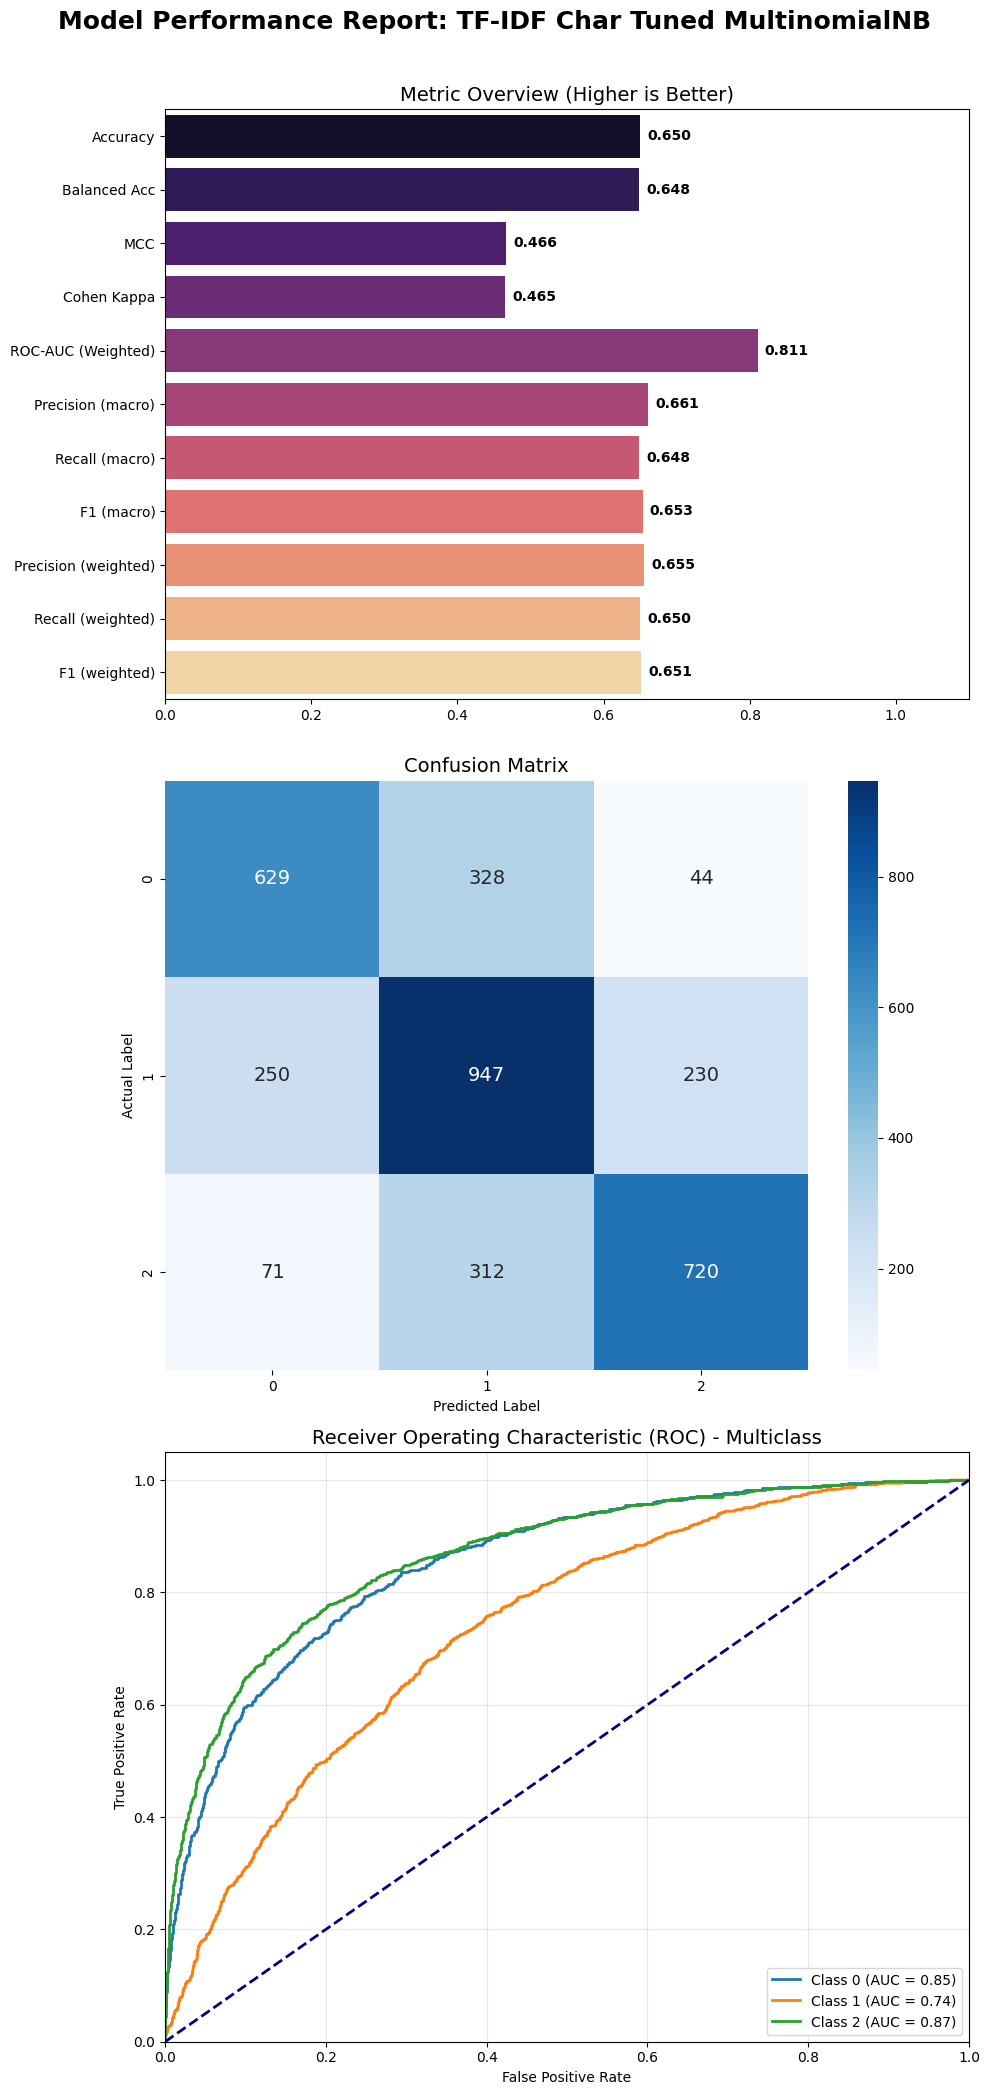

In [ ]:
print(f"Best Params: {nb_search.best_params_}")
evaluate_model(
    y_test,
    nb_search.predict(test_df['processed_text']),
    nb_search.predict_proba(test_df['processed_text']),
    "TF-IDF Char Tuned MultinomialNB"
)

### Gaussian Naive Bayes

In [14]:
def to_dense(X):
    return X.toarray()

dense_vectorizer = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char_wb")),
    ("to_dense", FunctionTransformer(to_dense, accept_sparse=True)),
])

param_grid_gnb = {
    "vec__tfidf__analyzer": ["char_wb"], 
    "vec__tfidf__ngram_range": [(2, 4), (3, 5)],
    "vec__tfidf__min_df": [1, 2],
    "vec__tfidf__max_df": [0.9, 1.0],
    "model__var_smoothing": np.logspace(0, -9, num=5),
}

gnb_search = tune_pipeline(dense_vectorizer, GaussianNB(), param_grid_gnb, 
                           train_df['processed_text'], y_train, 
                           model_name="GaussianNB_Char", use_parallel=False)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

#### Results:

--- Results for GaussianNB ---
Accuracy: 0.6126

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.71      0.62      1001
           1       0.62      0.49      0.55      1427
           2       0.67      0.69      0.68      1103

    accuracy                           0.61      3531
   macro avg       0.61      0.63      0.62      3531
weighted avg       0.62      0.61      0.61      3531



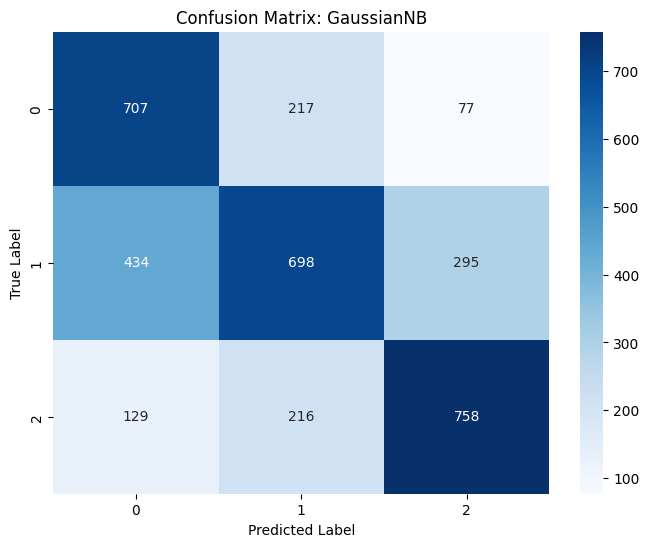

In [ ]:
evaluate_model(
    y_test,
    lr_search.predict(test_df['processed_text']),
    lr_search.predict_proba(test_df['processed_text'])
    "Logistic Regression Char-TFIDF"
)

### Logistic Regression

In [ ]:
param_grid_lr = {
    "vec__analyzer": ["char_wb"],
    "vec__ngram_range": [(2, 4), (3, 5)],
    "vec__min_df": [1, 2],
    "vec__max_df": [0.9, 1.0],
    "model__C": [0.1, 1, 10],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["saga"],
    "model__max_iter": [1000]
}

lr_search = tune_pipeline(vectorizer, LogisticRegression(), param_grid_lr, 
                          train_df['processed_text'], y_train, 
                          model_name="LogisticReg_Char")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\jdani\AppData\Local\pypoetry\Cache\virtualenvs\llm-based-sentiment-analysis-SE4PilyG-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\jdani\AppData\Local\pypoetry\Cache\virtualenvs\llm-based-sentiment-analysis-SE4PilyG-py3.12\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
C:\Users\jdani\AppData\Local\pypoetry\Cache\virtualenvs\llm-based-sentiment-analysis-SE4PilyG-py3.12\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

#### Results:

Best Parameters: {'model__C': 1, 'model__max_iter': 1000, 'model__penalty': 'l1', 'model__solver': 'saga'}
--- Results for Tuned Logistic Regression ---
Accuracy: 0.7052

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1001
           1       0.65      0.74      0.69      1427
           2       0.79      0.72      0.75      1103

    accuracy                           0.71      3531
   macro avg       0.72      0.70      0.71      3531
weighted avg       0.71      0.71      0.71      3531



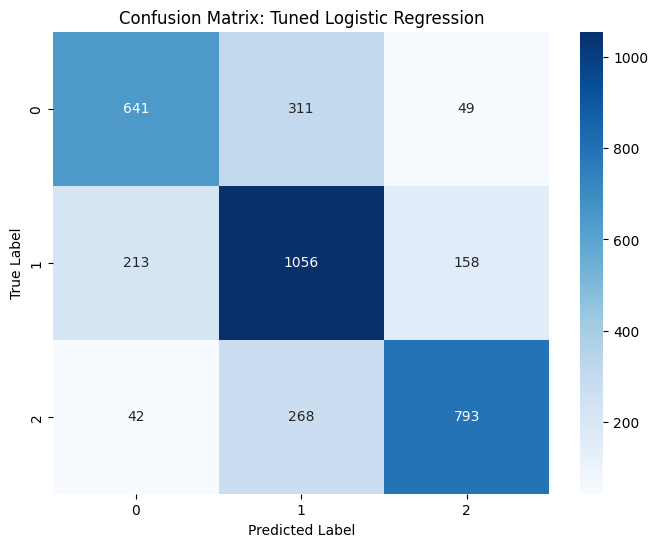

In [ ]:
evaluate_model(
    y_test,
    lr_search.predict(test_df['processed_text']),
    lr_search.predict_proba(test_df['processed_text']),
    "Logistic Regression Char-TFIDF"
)

### Linear SVM

In [ ]:
param_grid_svm = {
    "vec__analyzer": ["char_wb"],
    "vec__ngram_range": [(2, 4), (3, 5)],
    "vec__min_df": [1, 2],
    "vec__max_df": [0.9, 1.0],
    "model__estimator__C": [0.1, 1, 10]
}

svm_model = CalibratedClassifierCV(LinearSVC(dual=False, max_iter=2000))

svm_search = tune_pipeline(vectorizer, svm_model, param_grid_svm, 
                           train_df['processed_text'], y_train, 
                           model_name="LinearSVM_Char")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


#### Results:

Best Parameters: {'model__C': 0.1, 'model__loss': 'squared_hinge', 'model__max_iter': 2000}
--- Results for Tuned Linear SVM ---
Accuracy: 0.6975

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      1001
           1       0.64      0.74      0.69      1427
           2       0.77      0.71      0.74      1103

    accuracy                           0.70      3531
   macro avg       0.71      0.69      0.70      3531
weighted avg       0.70      0.70      0.70      3531



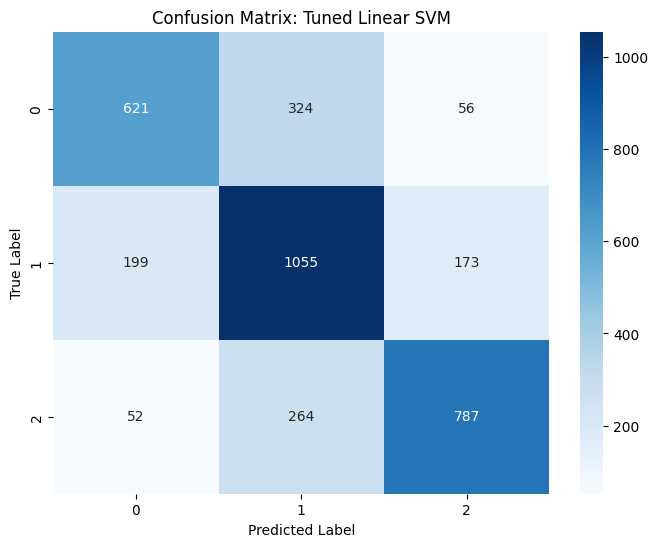

In [ ]:
evaluate_model(
    y_test,
    svm_search.predict(test_df['processed_text']),
    svm_search.predict_proba(test_df['processed_text']), 
    "Linear SVM Char-TFIDF"
)

### Random Forest / Bagging / Gradient Boosting

In [18]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 20],
    'model__min_samples_split': [2, 5],
    'model__class_weight': ['balanced', None] # Useful if classes are imbalanced
}

rf_search = tune_pipeline(vectorizer, RandomForestClassifier(n_jobs=-1), 
                          param_grid_rf, train_df['processed_text'], y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\jdani\AppData\Local\pypoetry\Cache\virtualenvs\llm-based-sentiment-analysis-SE4PilyG-py3.12\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#### Results:

Best Parameters: {'model__class_weight': 'balanced', 'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
--- Results for Tuned Random Forest ---
Accuracy: 0.7086

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.68      1001
           1       0.67      0.71      0.69      1427
           2       0.77      0.76      0.76      1103

    accuracy                           0.71      3531
   macro avg       0.71      0.71      0.71      3531
weighted avg       0.71      0.71      0.71      3531



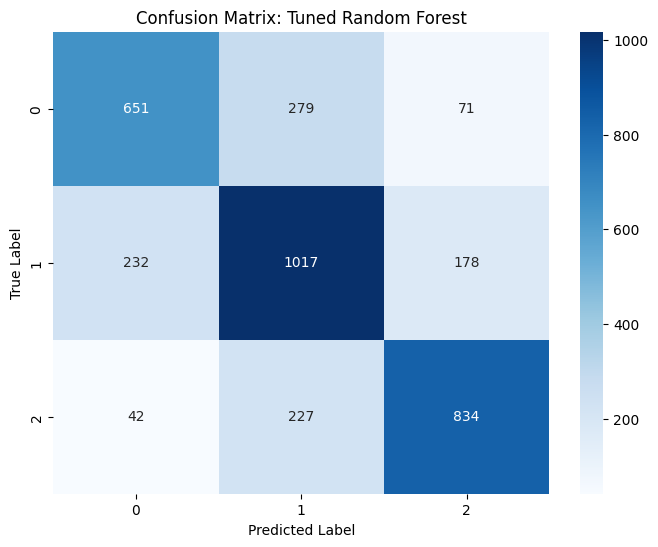

In [19]:
print(f"Best Parameters: {rf_search.best_params_}")
evaluate_model(y_test, rf_search.predict(test_df['processed_text']), "Tuned Random Forest")